<img src="../images/logos/wradlib_logo.svg.png" width=250 alt="wradlib logo png" align="left"></img>

# wradlib time series data and quasi vertical profiles

---

## Overview

Within this notebook, we will cover:

1. Reading radar sweep timeseries data into xarray based RadarVolume
1. Examination of RadarVolume and Sweep
1. Calculation of Quasivertical Profiles and Plotting

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Basic Plotting |
| [Xarray Basics](https://tutorial.xarray.dev/intro.html) | Helpful | Basic Dataset/DataArray |
| [Xarray Plotting](https://tutorial.xarray.dev/intro.html) | Helpful | Basic Plotting/Faceting |

- **Time to learn**: 7.5 minutes

---

## Imports

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from tqdm import tqdm_notebook as tqdm

import wradlib as wrl

## Import Australian Radar Data

It is assumed, that data from IDR71 (Terrey Hills, Sidney) from 20th of December 2018 is used in this notebook.

In [2]:
fglob = "data/hdf5/terrey_*.h5"
idr71 = glob.glob(fglob)
idr71.sort()
print("Files available: {}".format(len(idr71)))

Files available: 40


## Single Quasi Vertical Profile (QVP)


In [3]:
odh = xr.open_dataset(idr71[24], engine="odim")

In [4]:
display(odh)

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 200)
Coordinates:
  * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation          (azimuth) float32 ...
    time               (azimuth) datetime64[ns] ...
  * range              (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
Data variables: (12/13)
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    WRADH              (azimuth, range) float32 ...
    TH                 (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    RHOHV              (azimuth, range) float32 ...
    ...                 ...
    SNRH               (azimuth, range) float32 ...
    sweep_mode         <U20 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...

This example shows how to create a so called QVP. We need to define a function to add a height coordinate for plotting.

In [5]:
def add_height(ds):
    ds = ds.pipe(wrl.georef.georeference_dataset)
    height = ds.z.mean("azimuth")
    ds = ds.assign_coords({"height": (["range"], height.data)})
    return ds

Here we add the height coordinate and calculate the `mean` over the azimuth using the sweep with the highest available elevation.

In [6]:
swp = odh.pipe(add_height)
display(swp)

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 200)
Coordinates: (12/14)
  * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation          (azimuth) float32 32.0 32.0 32.0 32.0 ... 32.0 32.0 32.0
    time               (azimuth) datetime64[ns] ...
  * range              (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
    longitude          float64 151.2
    latitude           float64 -33.7
    ...                 ...
    y                  (azimuth, range) float32 106.0 318.0 ... 4.216e+04
    z                  (azimuth, range) float32 262.0 395.0 ... 2.673e+04
    gr                 (azimuth, range) float32 106.0 318.0 ... 4.216e+04
    rays               (azimuth, range) float32 0.5 0.5 0.5 ... 359.5 359.5
    bins               (azimuth, range) float32 125.0 375.0 ... 4.988e+04
    height             (range) float32 262.0 395.0 527.0 ... 2.66e+04 2.673e+04
Data variables: (12/13)
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    WRADH              (azimuth, range) float32 ...
    TH                 (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    RHOHV              (azimuth, range) float32 ...
    ...                 ...
    SNRH               (azimuth, range) float32 ...
    sweep_mode         <U20 'azimuth_surveillance'
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...

In [7]:
# Before applying the median we need to remove non-numerical variables otherwise it will fail. 
# We can move them too coordinates so to not lose them
qvp = swp.set_coords(["sweep_mode", "prt_mode", "follow_mode"]).median("azimuth")
qvp

<xarray.Dataset>
Dimensions:            (range: 200)
Coordinates:
  * range              (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
    sweep_mode         <U20 'azimuth_surveillance'
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    longitude          float64 151.2
    latitude           float64 -33.7
    altitude           float64 195.0
    height             (range) float32 262.0 395.0 527.0 ... 2.66e+04 2.673e+04
Data variables:
    DBZH               (range) float32 -1.5 -1.5 4.5 7.0 7.5 ... nan nan nan nan
    VRADH              (range) float32 -0.5158 -1.444 -2.991 ... nan nan nan
    WRADH              (range) float32 6.658 3.687 4.097 3.585 ... nan nan nan
    TH                 (range) float32 15.5 2.5 6.0 7.0 7.5 ... nan nan nan nan
    ZDR                (range) float32 -3.433 2.236 1.921 1.606 ... nan nan nan
    RHOHV              (range) float32 0.09842 0.687 0.7992 ... nan nan nan
    PHIDP              (range) float32 258.0 104.9 116.2 119.1 ... nan nan nan
    SNRH               (range) float32 54.5 46.5 48.0 47.5 ... 0.5 0.5 0.5 0.5
    sweep_number       float64 0.0
    sweep_fixed_angle  float64 32.0

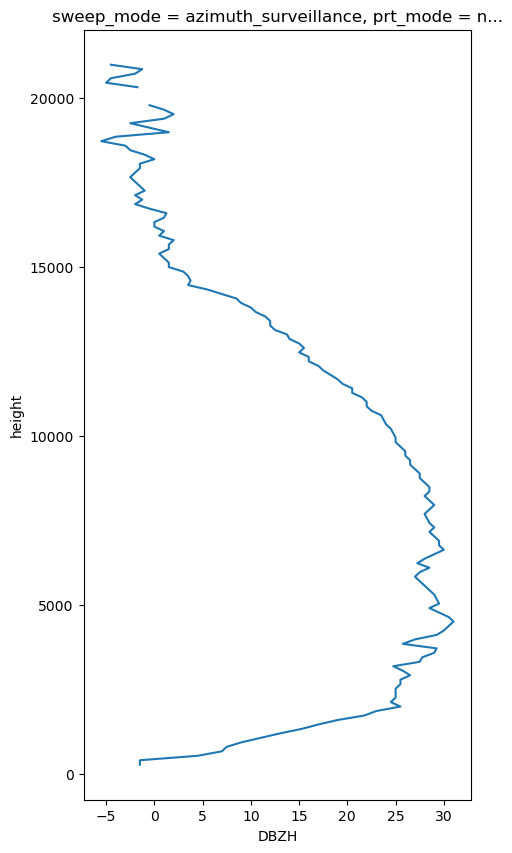

In [8]:
qvp.DBZH.plot(y="height", figsize=(5, 10))

## TimeSeries QVP

All wradlib xarray backends have the capability to read multiple sweeps/volumes in one go. We have to prepare the list of files a bit, though.

We have a time dimension for every ray (the coordinate time depends on azimuth), since xradar tries to adhere as much as possible to the cfradial standard. Then, we need to concatenate into a new dimension other than "time", otherwise it will fail. Another option would be to reduce the time dimension to only one value, we can use a preprocess function for that.

In [9]:
def preprocess(ds):
    ds.coords["time"] = ds.coords["time"].values.min()
    return ds

In [10]:
ts = xr.open_mfdataset(
    idr71,
    engine="odim",
    group="sweep_0",
    combine="nested",
    concat_dim="vtime",
#    preprocess=preprocess
)

In [11]:
display(ts)

<xarray.Dataset>
Dimensions:            (vtime: 40, azimuth: 360, range: 200)
Coordinates:
  * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation          (azimuth) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    time               (vtime, azimuth) datetime64[ns] dask.array<chunksize=(1, 360), meta=np.ndarray>
  * range              (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
    longitude          float64 151.2
    latitude           float64 -33.7
    altitude           float64 195.0
Dimensions without coordinates: vtime
Data variables: (12/13)
    DBZH               (vtime, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    VRADH              (vtime, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    WRADH              (vtime, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    TH                 (vtime, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    ZDR                (vtime, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    RHOHV              (vtime, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    ...                 ...
    SNRH               (vtime, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    sweep_mode         (vtime) <U20 'azimuth_surveillance' ... 'azimuth_surve...
    sweep_number       (vtime) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    prt_mode           (vtime) <U7 'not_set' 'not_set' ... 'not_set' 'not_set'
    follow_mode        (vtime) <U7 'not_set' 'not_set' ... 'not_set' 'not_set'
    sweep_fixed_angle  (vtime) float64 32.0 32.0 32.0 32.0 ... 32.0 32.0 32.0

### Georeference and add height coordinate

Here we have another issue if we want to use wradlib's georeference method. The method reads "sweep_mode" to separate volume scans from RHIs, but since the task information comes as variables in cfradial, it gets concatenated over time and the method will fail

In [12]:
ts.pipe(add_height)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

We could reduce it's dimension to only one value, or we can set is as a coordinate in the preprocessing function to avoid it's concatenation over time (as long as it does not change)

In [13]:
def preprocess(ds):
    ds.coords["time"] = ds.coords["time"].values.min()
    ds = ds.set_coords(["sweep_mode"])
    return ds

ts = xr.open_mfdataset(
    idr71,
    engine="odim",
    group="sweep_0",
    combine="nested",
    concat_dim="time",
    preprocess=preprocess
)

In [14]:
ts

<xarray.Dataset>
Dimensions:            (time: 40, azimuth: 360, range: 200)
Coordinates:
  * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation          (azimuth) float32 dask.array<chunksize=(360,), meta=np.ndarray>
  * time               (time) datetime64[ns] 2018-12-20T05:04:32.015277824 .....
  * range              (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
    sweep_mode         <U20 'azimuth_surveillance'
    longitude          float64 151.2
    latitude           float64 -33.7
    altitude           float64 195.0
Data variables:
    DBZH               (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    VRADH              (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    WRADH              (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    TH                 (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    ZDR                (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    RHOHV              (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    PHIDP              (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    SNRH               (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    sweep_number       (time) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    prt_mode           (time) <U7 'not_set' 'not_set' ... 'not_set' 'not_set'
    follow_mode        (time) <U7 'not_set' 'not_set' ... 'not_set' 'not_set'
    sweep_fixed_angle  (time) float64 32.0 32.0 32.0 32.0 ... 32.0 32.0 32.0

In [15]:
ts = ts.pipe(add_height)
display(ts)

<xarray.Dataset>
Dimensions:            (time: 40, azimuth: 360, range: 200)
Coordinates: (12/15)
  * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation          (azimuth) float32 dask.array<chunksize=(360,), meta=np.ndarray>
  * time               (time) datetime64[ns] 2018-12-20T05:04:32.015277824 .....
  * range              (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
    sweep_mode         <U20 'azimuth_surveillance'
    longitude          float64 151.2
    ...                 ...
    y                  (azimuth, range) float32 106.0 318.0 ... 4.216e+04
    z                  (azimuth, range) float32 262.0 395.0 ... 2.673e+04
    gr                 (azimuth, range) float32 106.0 318.0 ... 4.216e+04
    rays               (azimuth, range) float32 0.5 0.5 0.5 ... 359.5 359.5
    bins               (azimuth, range) float32 125.0 375.0 ... 4.988e+04
    height             (range) float32 262.0 395.0 527.0 ... 2.66e+04 2.673e+04
Data variables:
    DBZH               (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    VRADH              (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    WRADH              (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    TH                 (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    ZDR                (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    RHOHV              (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    PHIDP              (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    SNRH               (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    sweep_number       (time) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    prt_mode           (time) <U7 'not_set' 'not_set' ... 'not_set' 'not_set'
    follow_mode        (time) <U7 'not_set' 'not_set' ... 'not_set' 'not_set'
    sweep_fixed_angle  (time) float64 32.0 32.0 32.0 32.0 ... 32.0 32.0 32.0

### Calculate Statistics

In [16]:
stats = ["median", "mean", "min", "max"]
stat = [
    getattr(ts.where(ts.RHOHV > 0.8), st)("azimuth", skipna=True, keep_attrs=True)
    for st in stats
]
ts_stats = xr.concat(stat, dim="stats")
ts_stats = ts_stats.assign_coords({"stats": stats})

In [17]:
display(ts_stats)

<xarray.Dataset>
Dimensions:            (stats: 4, time: 40, range: 200)
Coordinates:
  * time               (time) datetime64[ns] 2018-12-20T05:04:32.015277824 .....
  * range              (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
    sweep_mode         <U20 'azimuth_surveillance'
    longitude          float64 151.2
    latitude           float64 -33.7
    altitude           float64 195.0
    height             (range) float32 262.0 395.0 527.0 ... 2.66e+04 2.673e+04
  * stats              (stats) <U6 'median' 'mean' 'min' 'max'
Data variables:
    DBZH               (stats, time, range) float32 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    VRADH              (stats, time, range) float32 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    WRADH              (stats, time, range) float32 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    TH                 (stats, time, range) float32 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    ZDR                (stats, time, range) float32 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    RHOHV              (stats, time, range) float32 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    PHIDP              (stats, time, range) float32 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    SNRH               (stats, time, range) float32 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    sweep_number       (stats, time, range) float64 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    sweep_fixed_angle  (stats, time, range) float64 dask.array<chunksize=(1, 1, 200), meta=np.ndarray>
    prt_mode           (stats, time, range) object dask.array<chunksize=(3, 1, 200), meta=np.ndarray>
    follow_mode        (stats, time, range) object dask.array<chunksize=(3, 1, 200), meta=np.ndarray>

### Plot QVP's

/home/jgiles/mambaforge/envs/wradlib4/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/jgiles/mambaforge/envs/wradlib4/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/jgiles/mambaforge/envs/wradlib4/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/jgiles/mambaforge/envs/wradlib4/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/jgiles/mambaforge/envs/wradlib4/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return fu

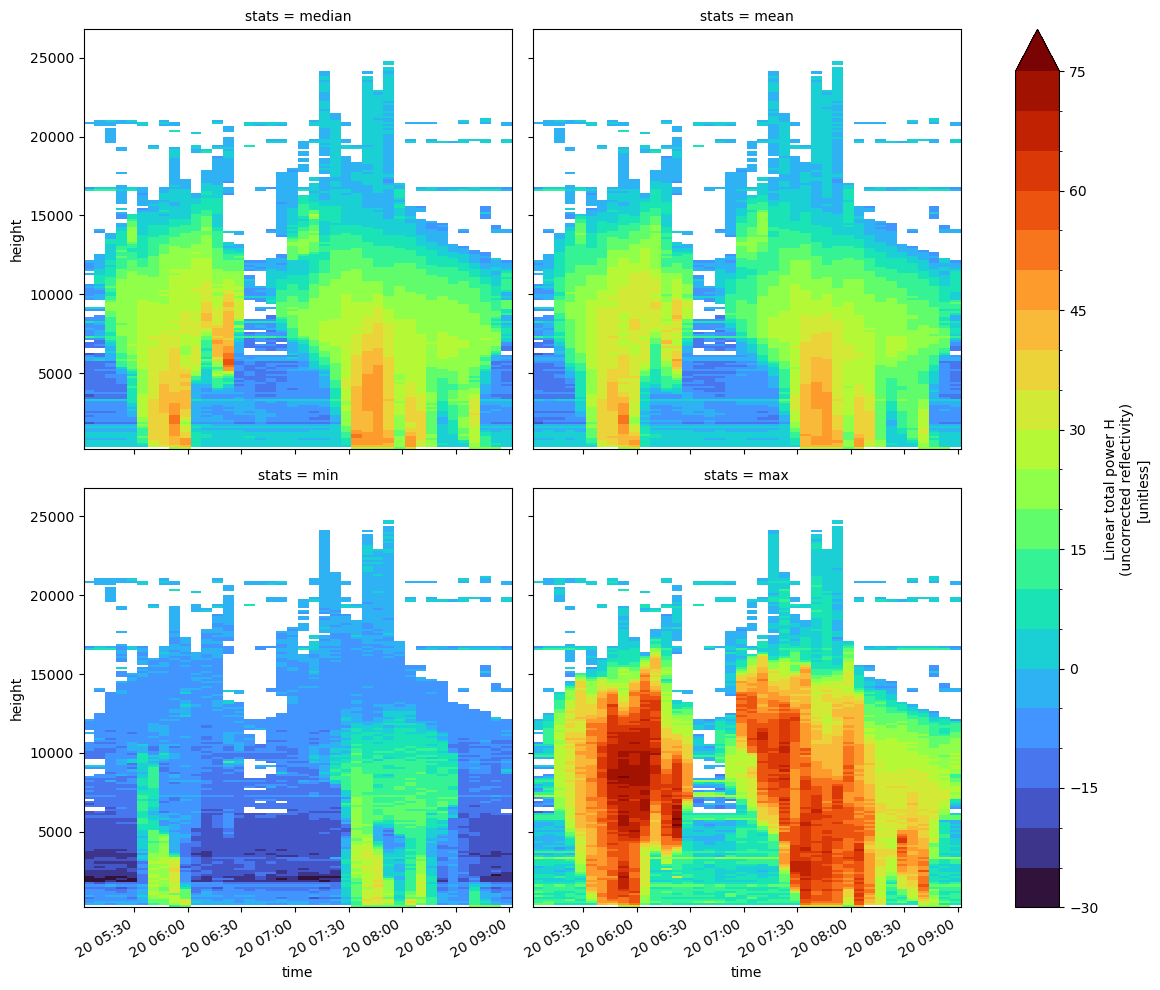

In [18]:
levels = np.arange(-30, 80, 5)
facet = ts_stats.TH.plot(
    x="time",
    y="height",
    col="stats",
    col_wrap=2,
    cmap="turbo",
    figsize=(12, 10),
    levels=levels,
)

---

## Summary
Easy creation of Quasi Vertical Profiles was shown.


## Resources and references

- [xarray](https://docs.xarray.dev)
- [dask](https://docs.dask.org/)
- [wradlib xarray backends](https://docs.wradlib.org/en/stable/notebooks/fileio/wradlib_xarray_backends.html)
- [OPERA ODIM_H5](https://www.eumetnet.eu/activities/observations-programme/current-activities/opera/)
- [WMO JET-OWR](https://community.wmo.int/governance/commission-membership/commission-observation-infrastructure-and-information-systems-infcom/commission-infrastructure-officers/infcom-management-group/standing-committee-measurements-instrumentation-and-traceability-sc-mint/joint-expert-team)